# Spatio-temporal mineral prospectivity mapping of Papua New Guinea

In [2]:
# setup the working environment
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

import base64, glob, io, os
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import contextily as cx
import convergence, Utils
import coregistration
from create_coregistration_input_data_example import *
import csv
from IPython.display import HTML
import matplotlib.cm as cm
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import moviepy.editor as mpy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from parameters import parameters
from pprint import pprint
from pulearn import BaggingPuClassifier
import pygplates
import re
import requests
from scipy import misc, ndimage
from scipy.interpolate import griddata
import seaborn as sns
import shapefile
from shapely.geometry.polygon import LinearRing
import TopoMap
import Utils

# machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# load the config file
Utils.load_config('config.json')
Utils.print_parameters()

Below are the parameters in use. Check the parameters carefully to ensure a sucussful run.
{ 'agegrid_url': 'https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2016_AREPS/Muller_etal_2016_AREPS_Agegrids/Muller_etal_2016_AREPS_Agegrids_v1.17/Muller_etal_2016_AREPS_v1.17_netCDF/Muller_etal_2016_AREPS_v1.17_AgeGrid-{}.nc',
  'anchor_plate_id': 0,
  'case_name': 'default-test-case-name',
  'coastlines': '../Muller_2016/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz',
  'convergence_data_dir': './convergence_data/',
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'subStats',
  'coreg_input_dir': './coreg_input/',
  'coreg_input_files': [ 'samples.csv',
                         'random_samples.csv',
                         'mineral_occurrences.csv'],
  'coreg_output_dir': 'coreg_output',
  'deposit_path': '../GIS/min_occ_holm_porphyry.shp',
  'feature_names': [ 'dist_nearest_edge',
                     'trench_abs_ortho',
                

# Convergence Kinematics

In [3]:
print('Extracting convergence kinematics statistics ...')
print('This may take a while; please be patient!\n')

# run the convergence script
# this will generate a bunch of subduction convergence kinematics statistics files
# by default, the files are placed in ./convergence_data
convergence.run_it()

# list all the output files
conv_dir = Utils.get_convergence_dir()
files = sorted(glob.glob(conv_dir + '*'), key=os.path.getmtime)
print('The number of generated files:', len(files))
print('The first 10 files:')

for i in range(10):
    print(files[i])
    
time = 0.
pd.read_csv(f"{conv_dir}{Utils.get_parameter('convergence_data_filename_prefix')}_\
{time:0.2f}.{Utils.get_parameter('convergence_data_filename_ext')}")

Extracting convergence kinematics statistics ...
This may take a while; please be patient!

Generating convergence data ...
Convergence data exist in ./convergence_data/. Do not recreate again. Do nothing and return.
The number of generated files: 231
The first 10 files:
./convergence_data\subStats_230.00.csv
./convergence_data\subStats_229.00.csv
./convergence_data\subStats_228.00.csv
./convergence_data\subStats_227.00.csv
./convergence_data\subStats_226.00.csv
./convergence_data\subStats_225.00.csv
./convergence_data\subStats_224.00.csv
./convergence_data\subStats_223.00.csv
./convergence_data\subStats_222.00.csv
./convergence_data\subStats_221.00.csv


trench_lon  trench_lat  conv_rate  conv_angle  trench_abs_rate  \
0        -144.44       60.46       4.76       13.76             1.91   
1        -144.75       60.35       4.79       13.70             1.91   
2        -145.06       60.24       4.81       13.64             1.90   
3        -145.37       60.12       4.83       13.58             1.90   
4        -145.68       60.01       4.85       13.52             1.90   
...          ...         ...        ...         ...              ...   
3056        4.88       36.33       0.71      -20.82            -0.55   
3057        4.63       36.33       0.71      -20.94            -0.55   
3058        4.38       36.33       0.70      -21.05            -0.55   
3059        4.14       36.32       0.70      -21.16            -0.54   
3060        3.92       36.32       0.70      -21.27            -0.54   

      trench_abs_angle  arc_len  trench_norm  subducting_pid  trench_pid  ...  \
0              -135.18     0.19       324.26             901         111  ...   
1              -135.06     0.19       323.98             901         111  ...   
2              -134.94     0.19       323.71             901         111  ...   
3              -134.82     0.19       323.45             901         111  ...   
4              -134.70     0.19       323.18             901         111  ...   
...                ...      ...          ...             ...         ...  ...   
3056             17.06     0.20       359.33             701         707  ...   
3057             17.18     0.20       359.18             701         707  ...   
3058             17.30     0.20       359.04             701         707  ...   
3059             17.42     0.18       358.90             701       70833  ...   
3060             17.54     0.18       358.76             701       70833  ...   

      trench_abs_paral  subducting_abs_rate  subducting_abs_angle  \
0                -1.35                -3.29                 -3.97   
1                -1.35                -3.31                 -3.94   
2                -1.35                -3.34                 -3.91   
3                -1.35                -3.37                 -3.87   
4                -1.35                -3.40                 -3.84   
...                ...                  ...                   ...   
3056              0.16                -1.20                 -4.29   
3057              0.16                -1.19                 -4.32   
3058              0.16                -1.18                 -4.35   
3059              0.16                -1.17                 -4.37   
3060              0.16                -1.17                 -4.40   

      subducting_abs_ortho  subducting_abs_paral  seafloor_age  \
0                     3.28                 -0.23         34.77   
1                     3.31                 -0.23         34.77   
2                     3.33                 -0.23         34.77   
3                     3.36                 -0.23         34.77   
4                     3.39                 -0.23         34.77   
...                    ...                   ...           ...   
3056                  1.19                 -0.09         20.95   
3057                  1.19                 -0.09         20.95   
3058                  1.18                 -0.09         20.51   
3059                  1.17                 -0.09         20.51   
3060                  1.16                 -0.09         20.51   

      subduction_volume_km3y  carbonate_sediment_thickness  \
0                       0.06                         29.96   
1                       0.06                         27.83   
2                       0.06                         27.83   
3                       0.06                         27.83   
4                       0.06                         27.83   
...                      ...                           ...   
3056                    0.01                         48.56   
3057                    0.01                      

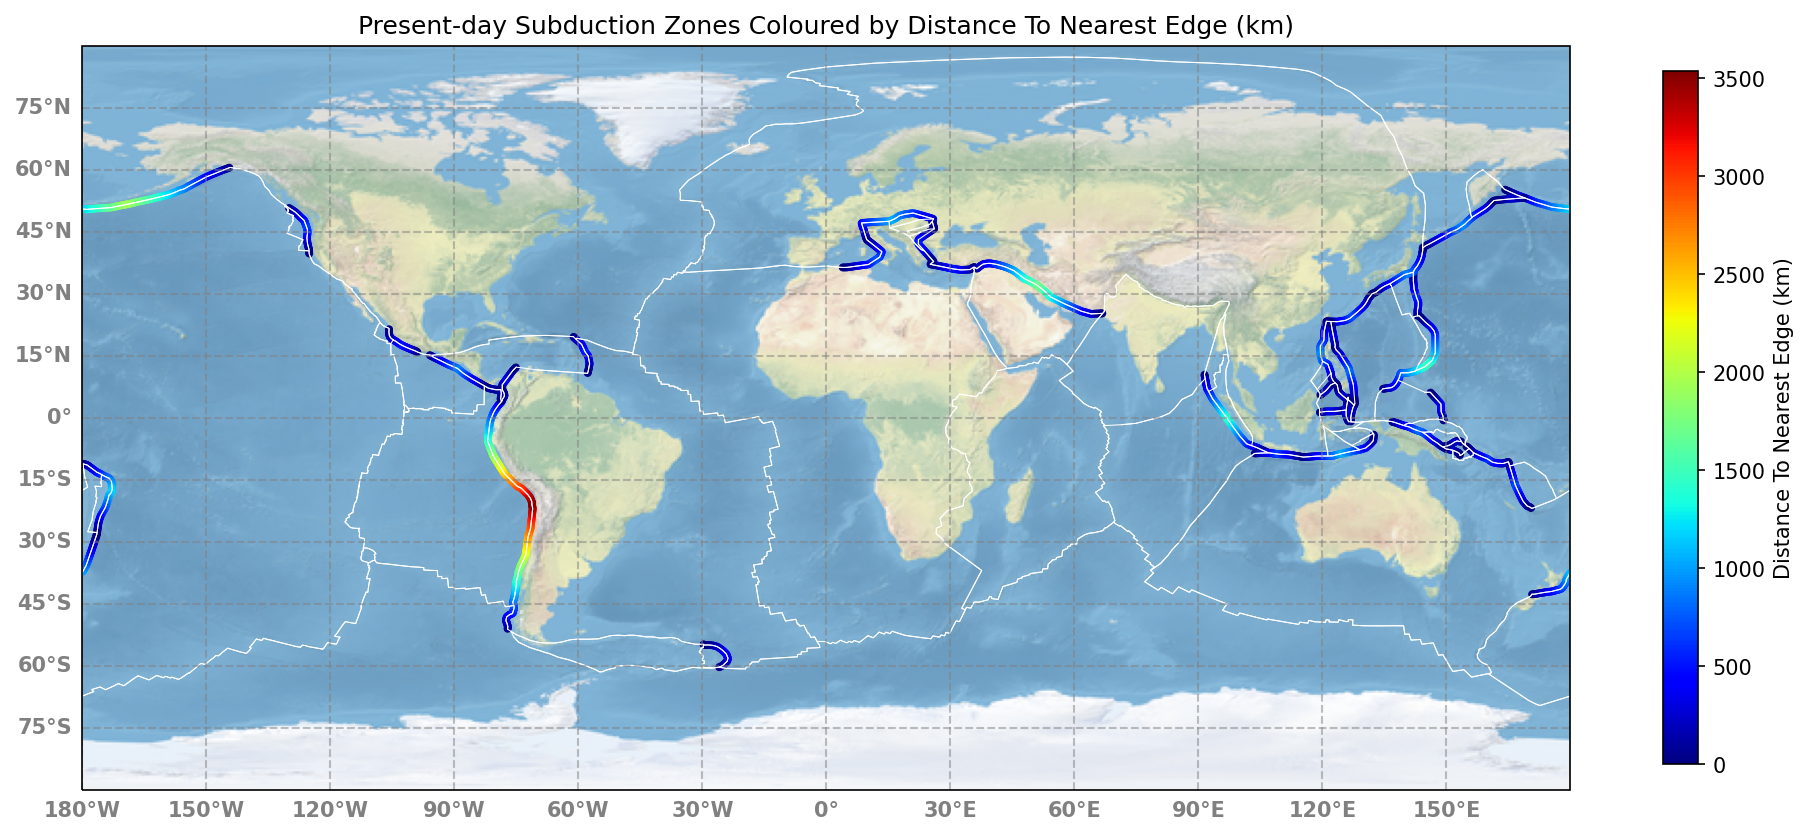

In [4]:
trench_data = Utils.get_trench_points(0)

# get topological plate boundaries
time = 0
resolved_topologies = []
shared_boundary_sections = []

rotation_files = Utils.get_files(Utils.get_parameter('rotation_files'))
topology_files = Utils.get_files(Utils.get_parameter('topology_files'))

# use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)

geoms = [t.get_resolved_boundary() for t in resolved_topologies]

# plot the data in a global map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
for geom in geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='white', linewidth=.5, # topological plate boundaries in white
             transform=ccrs.Geodetic()
            )

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(range(-180, 180, 30))
gl.ylocator = mticker.FixedLocator(range(-90, 90, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

# subduction sample points are colored by property value
cb = ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 30, marker='.',
                c=trench_data['dist_nearest_edge'] * 6371. * np.pi / 180, cmap=plt.cm.jet)
plt.title('Present-day Subduction Zones Coloured by Distance To Nearest Edge (km)')
fig.colorbar(cb, shrink=0.5, label='Distance To Nearest Edge (km)')
plt.show()

reading ../GIS/PNG_Papua_Dissolved_CH_Points.csv


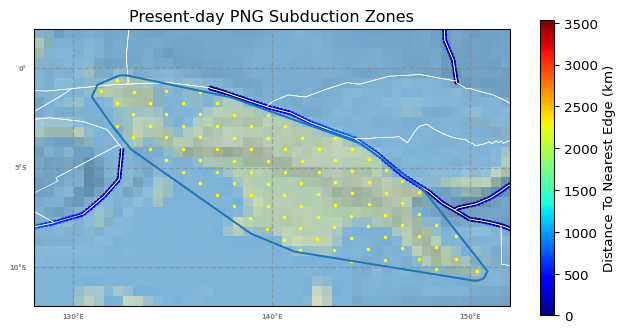

In [5]:
region_of_interest_polygon = Utils.get_region_of_interest_polygon()
# display(region_of_interest_polygon)

mesh_points = Utils.get_mesh_points(region_of_interest_polygon.values.flatten())

# plot the data in a regional map
fig = plt.figure(figsize=(8, 8), dpi=96)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent(Utils.get_region_of_interest_extent())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([130, 140, 150])
gl.ylocator = mticker.FixedLocator([-10, -5, 0])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

for geom in geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='white', linewidth=.5, # topological plate boundaries in white
             transform=ccrs.Geodetic()
            )

# subduction sample points are colored by property value; see 'color_by' above
cb = ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 30, marker='.', 
                c=trench_data['dist_nearest_edge'] * 6371. * np.pi / 180, cmap=plt.cm.jet)
plt.plot(region_of_interest_polygon['lon'], region_of_interest_polygon['lat'], transform=ccrs.Geodetic())
ax.scatter(mesh_points['lon'], mesh_points['lat'], 10, marker='.', color='yellow')
plt.title('Present-day PNG Subduction Zones')
fig.colorbar(cb, shrink=0.5, label='Distance To Nearest Edge (km)')
plt.show()

./AgeGrids/Muller_etal_2016_AREPS_v1.17_AgeGrid-0.nc
Reconstructing geometries ...


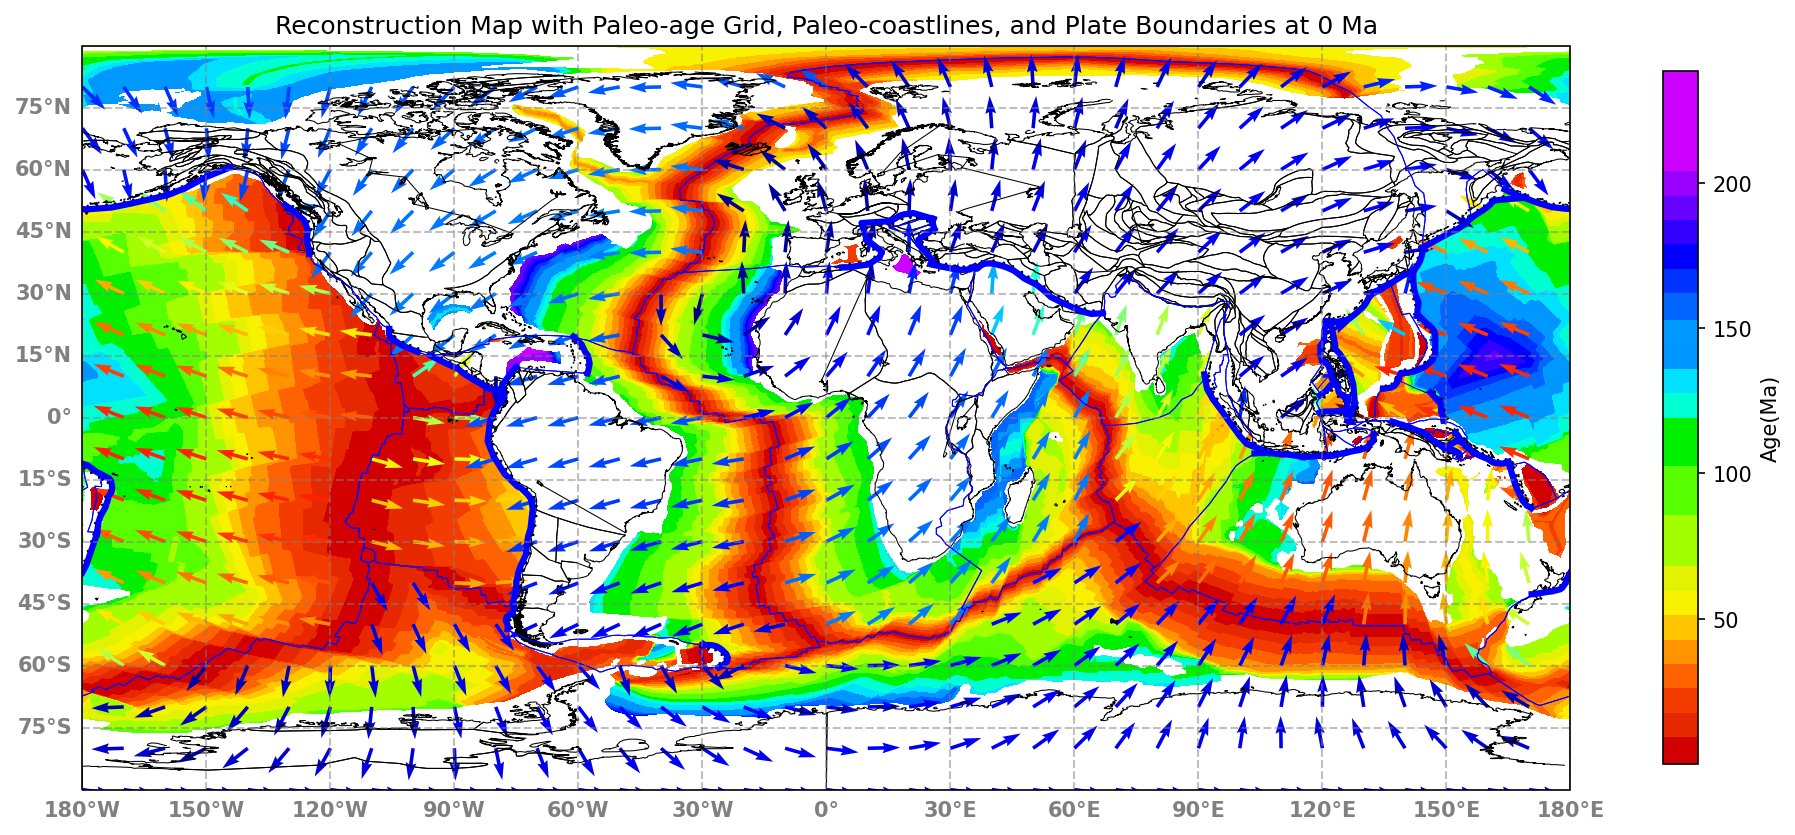

In [6]:
time = 0
draw_velocity_vectors = True

# change the extent to see a specific area
map_extent = [-180, 180, -90, 90] # global

agegrid_file = Utils.download_agegrid(time)
print(agegrid_file)
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

# reconstruct coastlines and topology
print('Reconstructing geometries ...')

resolved_topologies = []
shared_boundary_sections = []
# use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)

# coastlines
reconstructed_geometries = []
pygplates.reconstruct(
    Utils.get_parameter('coastlines'),  
    rotation_files, 
    reconstructed_geometries, 
    time,
    0
)

# subduction zones
subduction_geoms = []
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

# velocity vectors
x, y, u, v = Utils.get_velocity_x_y_u_v(time, pygplates.RotationModel(rotation_files), topology_files)
       
# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent(map_extent)

if agegrid_file:
    img = Dataset(agegrid_file) # age grid
    cb = ax.imshow(img.variables['z'], origin='lower', transform=ccrs.PlateCarree(),
                   extent=[-180, 180, -90, 90], cmap=agegrid_cmap)

# plot coastlines
for geom in reconstructed_geometries:
    lat, lon = zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='black', linewidth=.5, # coastlines in black
             transform=ccrs.Geodetic()
            )

# plot topological plate boundaries
for t in resolved_topologies:
    lat, lon = zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='blue', linewidth=.5, # topological plate boundaries in blue
             transform=ccrs.Geodetic()
            )

# plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='blue', linewidth=3, # subduction zones in blue
             transform=ccrs.Geodetic()
            )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)

if draw_velocity_vectors:
    # draw velocity vectors
    # some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude
    # and use color to denote different magnitudes
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    ax.quiver(x, y, u, v, mag,transform=ccrs.PlateCarree(), cmap='jet')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

if agegrid_file:
    plt.title(f'Reconstruction Map with Paleo-age Grid, Paleo-coastlines, and Plate Boundaries at {time} Ma')
    fig.colorbar(cb, shrink=0.5, label='Age(Ma)')
else:
    plt.title(f'Reconstruction Map with Paleo-coastlines and Plate Boundaries at {time} Ma')

plt.show()

./AgeGrids/Muller_etal_2016_AREPS_v1.17_AgeGrid-0.nc
Reconstructing geometries ...


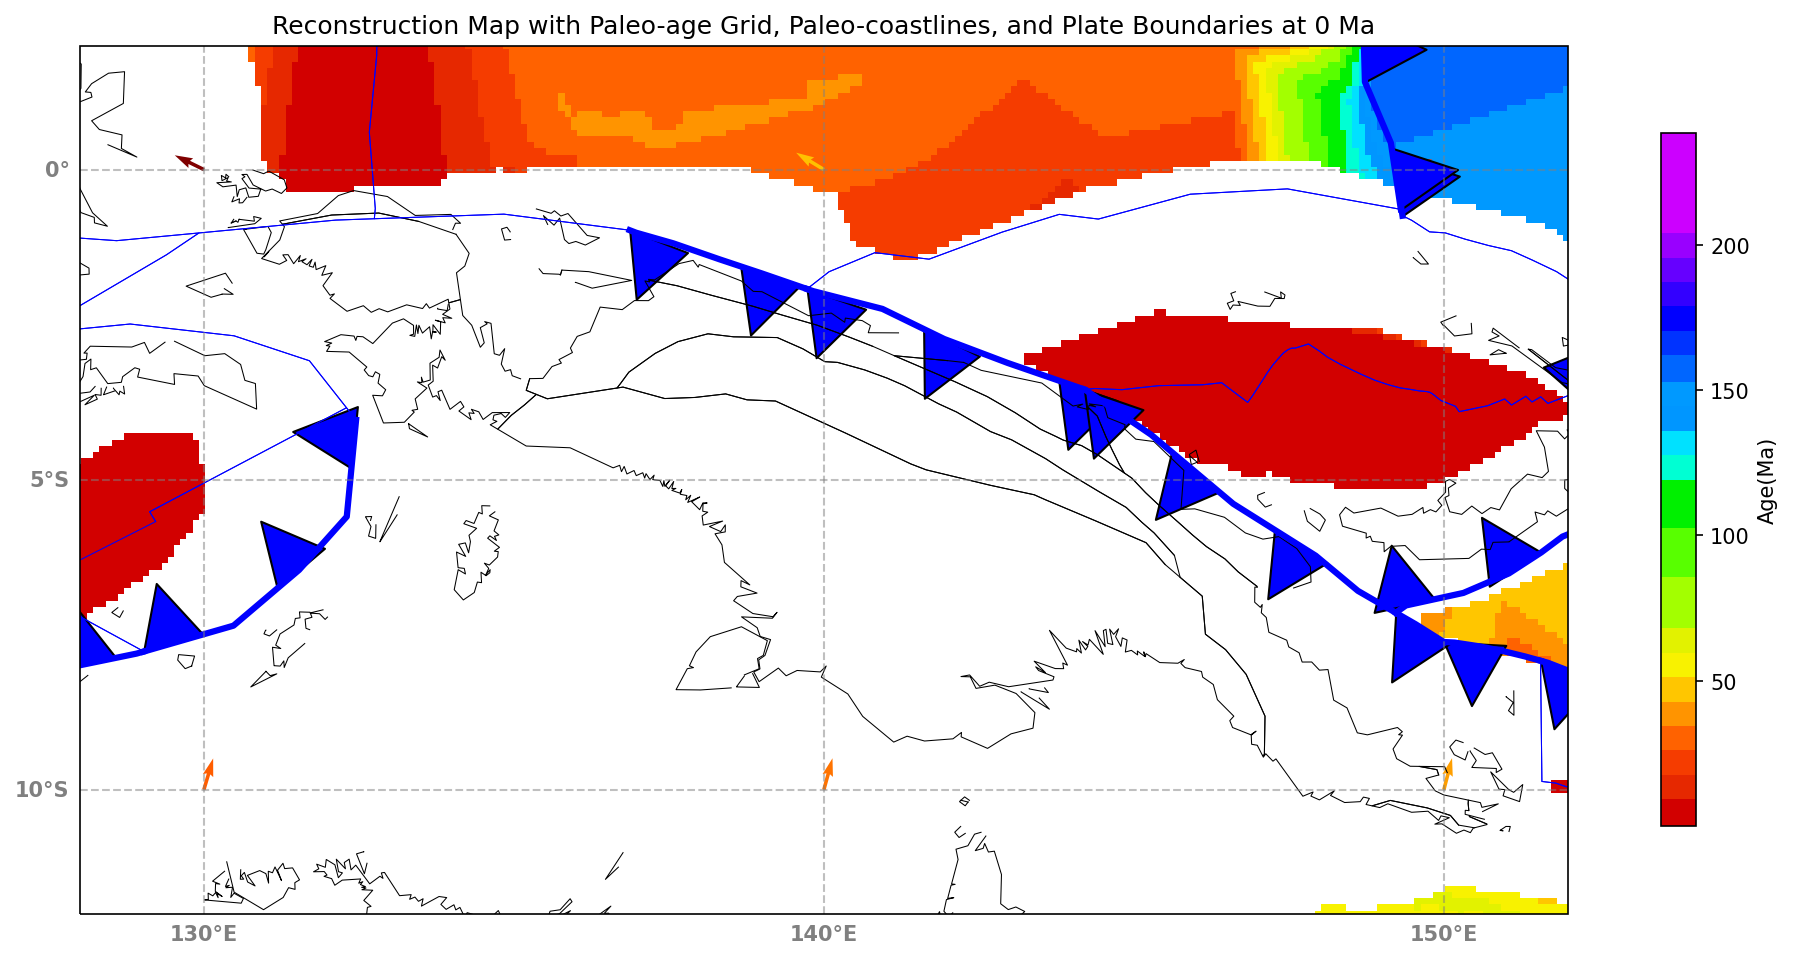

In [7]:
time = 0
draw_velocity_vectors = True

# change the extent to see a specific area
map_extent = [128, 152, -12, 2] # png

agegrid_file = Utils.download_agegrid(time)
print(agegrid_file)
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

# reconstruct coastlines and topology
print('Reconstructing geometries ...')

resolved_topologies = []
shared_boundary_sections = []
# use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)

# coastlines
reconstructed_geometries = []
pygplates.reconstruct(
    Utils.get_parameter('coastlines'),  
    rotation_files, 
    reconstructed_geometries, 
    time,
    0
)

# subduction zones
subduction_geoms = []
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

# velocity vectors
x, y, u, v = Utils.get_velocity_x_y_u_v(time, pygplates.RotationModel(rotation_files), topology_files)
       
# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent(map_extent)

if agegrid_file:
    img = Dataset(agegrid_file) # age grid
    cb = ax.imshow(img.variables['z'], origin='lower', transform=ccrs.PlateCarree(),
                   extent=[-180, 180, -90, 90], cmap=agegrid_cmap)

# plot coastlines
for geom in reconstructed_geometries:
    lat, lon = zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='black', linewidth=.5, # coastlines in black
             transform=ccrs.Geodetic()
            )

# plot topological plate boundaries
for t in resolved_topologies:
    lat, lon = zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='blue', linewidth=.5, # topological plate boundaries in blue
             transform=ccrs.Geodetic()
            )

# plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='blue', linewidth=3, # subduction zones in blue
             transform=ccrs.Geodetic()
            )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)

if draw_velocity_vectors:
    # draw velocity vectors
    # some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude
    # and use color to denote magnitudes
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    ax.quiver(x, y, u, v, mag,transform=ccrs.PlateCarree(), cmap='jet')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([130, 140, 150])
gl.ylocator = mticker.FixedLocator([-10, -5, 0])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

if agegrid_file:
    plt.title(f'Reconstruction Map with Paleo-age Grid, Paleo-coastlines, and Plate Boundaries at {time} Ma')
    fig.colorbar(cb, shrink=0.5, label='Age(Ma)')
else:
    plt.title(f'Reconstruction Map with Paleo-coastlines and Plate Boundaries at {time} Ma')

plt.show()

In [ ]:
p_time = Utils.get_parameter('time')
start_time = p_time['start'] 
end_time = p_time['end']
time_step = p_time['step']

map_extent = [-180, 180, -90, 90]
 
rotation_files = Utils.get_files(Utils.get_parameter('rotation_files'))
coastlines_file = Utils.get_parameter('coastlines')

for time in range(start_time, end_time+1, 10):
    # coastlines
    reconstructed_geometries = []
    pygplates.reconstruct(
        coastlines_file,
        rotation_files,
        reconstructed_geometries,
        time,
        0
    )

    # subduction zones
    '''
    topology_files = Utils.get_files(Utils.get_parameter('topology_files'))
    resolved_topologies = []
    shared_boundary_sections = []
    # use pygplates to resolve the topologies
    pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, 
                                 shared_boundary_sections)
    subduction_geoms = []
    Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)
    '''

    # plot the map
    fig = plt.figure(figsize=(16, 12), dpi=144)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent(map_extent)

    # plot coastlines
    for geom in reconstructed_geometries:
        lat, lon = zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
        plt.plot(lon, lat,
                 color='black', linewidth=.5, # the coastlines in black
                 transform=ccrs.Geodetic()
                )

    # plot subduction zones
    '''
    for geom, aspect in subduction_geoms:
        lat, lon = zip(*(geom.to_lat_lon_list()))
        plt.plot(lon, lat,
                color='blue', linewidth=1, # subduction zones in blue
                transform=ccrs.Geodetic()
                )
        teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
        for tooth in teeth:
            ring = LinearRing(tooth)
            ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)
    '''

    trench_data = Utils.get_trench_points(time)
    # the subduction sample points are colored by property value. see 'color_by' above
    cb=ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 50, marker='.', 
                  c=trench_data['dist_nearest_edge']*6371.*np.pi/180, cmap=plt.cm.jet, vmax=3000, vmin=0)

    fig.colorbar(cb, shrink=0.5, label='Distance To Nearest Edge(km)')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
    gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

    plt.title(f'Subduction Zones at {time} Ma')
    plt.savefig(Utils.get_tmp_dir() + f'subduction_zones_{time}_Ma.png',bbox_inches='tight',pad_inches=0)
    print(f'plotting {time} Ma')
    plt.close()
    # plt.show()

In [ ]:
p_time = Utils.get_parameter('time')
start_time = p_time['start']
end_time = p_time['end']
time_step = p_time['step']

# frame_list = [Utils.get_tmp_dir() + f'subduction_zones_{time}_Ma.png' for time in range(start_time, end_time+1, 10)]
frame_list = [Utils.get_tmp_dir() + f'subduction_zones_{time}_Ma.png' for time in range(end_time, start_time-1, -10)]
clip = mpy.ImageSequenceClip(frame_list, fps=2)
clip.write_gif(Utils.get_tmp_dir() + 'subduction_zones.gif')
clip.write_videofile(Utils.get_tmp_dir() + 'subduction_zones.mp4')
print('done')

In [ ]:
video = io.open(Utils.get_tmp_dir() + 'subduction_zones.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width=960 alt='subduction zones animation' controls>
<source src='data:video/mp4;base64,{0}' type='video/mp4' /> </video>'''.format(encoded.decode('ascii')))

# Mineral Occurrences

In [8]:
# get start time, end time, and time step from parameters.py
start_time = parameters['time']['start']
end_time = parameters['time']['end']
time_step = parameters['time']['step']
deposit_path = parameters['deposit_path']
polygon_path = parameters['region_of_interest_polygon']
convergence_file = parameters['convergence_data_dir']+parameters['convergence_data_filename_prefix']+'_0.00.csv'
num_features = pd.read_csv(convergence_file).shape[1]
map_extent = parameters['map_extent']
dist_x = 0.4
dist_y = 0.4

# id, lon, lat, age, and plate id of mineral occurrences
min_occ_data = process_real_deposits(deposit_path, start_time, end_time, time_step)

# save the attributes of mineral occurrences
min_occ_data = pd.DataFrame(min_occ_data, columns=['index', 'lon', 'lat', 'age', 'plate_id'])
min_occ_data = min_occ_data.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
min_occ_data.to_csv(Utils.get_coreg_input_dir() + 'mineral_occurrences.csv', index=False)

# generate random samples and extract id, lon, lat, age, and plate id
random_data = generate_non_deposits(polygon_path, start_time, end_time, num_features)

# save the attributes of random samples
random_data = pd.DataFrame(random_data, columns=['index', 'lon','lat','age','plate_id'])
random_data = random_data.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
random_data.to_csv(Utils.get_coreg_input_dir() + 'random_samples.csv', index=False)

# generate samples
sample_data, mask_coords, nx, ny = generate_samples(polygon_path, dist_x, dist_y, start_time, end_time, map_extent)

# save the attributes of samples
sample_data = pd.DataFrame(sample_data, columns=['index', 'lon','lat','age','plate_id'])
sample_data = sample_data.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
sample_data.to_csv(Utils.get_coreg_input_dir() + 'samples.csv', index=False)

# save the mask
mask_coords = pd.DataFrame(mask_coords, columns=['lon','lat', 'include'])
mask_coords.to_csv(Utils.get_coreg_input_dir() + 'mask.csv', index=False)

125 random samples generated successfully!


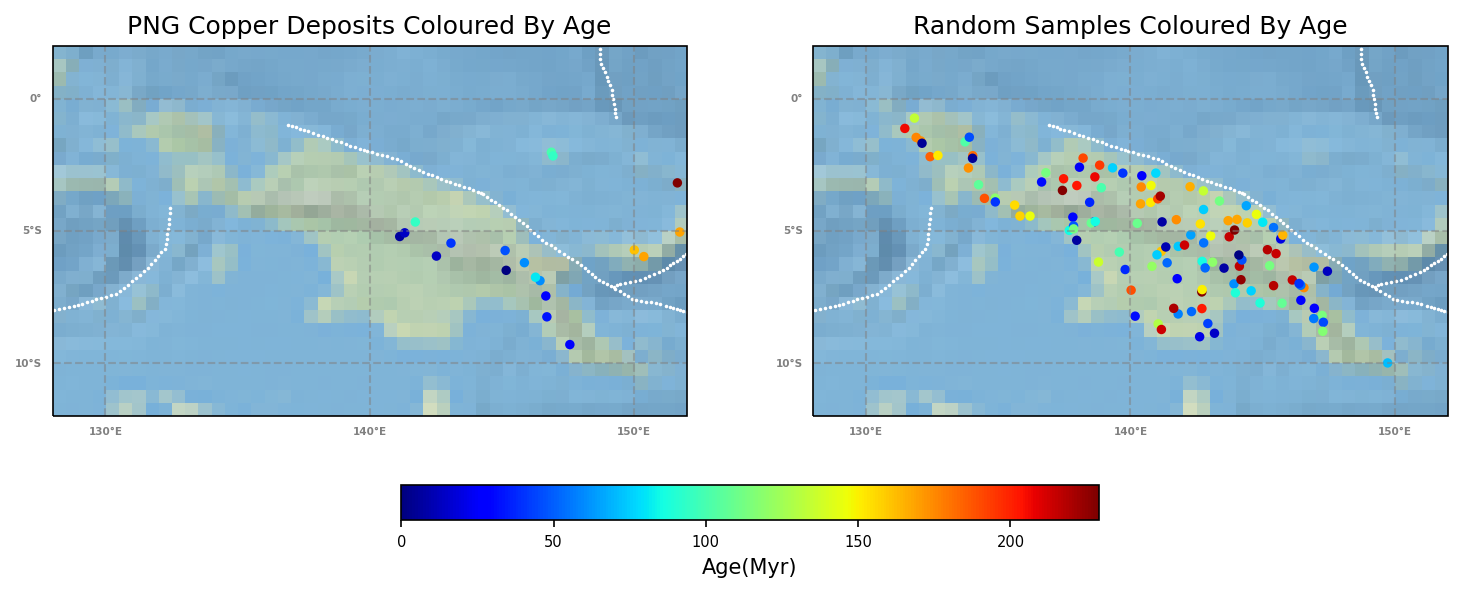

In [9]:
def set_ax(ax):
    ax.stock_img()
    ax.set_extent([128, 152, -12, 2])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([130, 140, 150])
    gl.ylocator = mticker.FixedLocator([-10, -5, 0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

trench_file = Utils.get_convergence_dir() + 'subStats_0.00.csv'
# trench_file = './convergence_data/AREPS/subStats_0.00.csv'
trench_data = np.genfromtxt(trench_file, skip_header=1, delimiter=',')

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12), dpi=150)
set_ax(ax1)
set_ax(ax2)

cb = ax1.scatter(min_occ_data['lon'], min_occ_data['lat'], 50, marker='.', c=min_occ_data['age'], cmap=plt.cm.jet)
cb = ax2.scatter(random_data['lon'], random_data['lat'], 50, marker='.', c=random_data['age'], cmap=plt.cm.jet)
# cb = ax2.scatter(sample_data.loc[sample_data['age'] == 0]['lon'], sample_data.loc[sample_data['age'] == 0]['lat'], 50, marker='.')
ax1.scatter(trench_data[:, 0], trench_data[:, 1], 2, marker='.', color='white') # draw trench poinys in white
ax2.scatter(trench_data[:, 0], trench_data[:, 1], 2, marker='.', color='white') # draw trench points in white
ax1.title.set_text('PNG Copper Deposits Coloured By Age')
ax2.title.set_text('Random Samples Coloured By Age')
cbar = fig.colorbar(cb, shrink=0.5, ax=[ax1, ax2], orientation='horizontal', pad=0.05)
cbar.set_label('Age(Myr)', size=10)
cbar.ax.tick_params(labelsize=7)
plt.show()

# Coregistration

In [10]:
# print out some important parameters
# change the 'input_file' in config.json to use different mineral deposits
print('The file name of the mineral deposits:', Utils.get_parameter('coreg_input_files'))
print('The output folder:', Utils.get_coreg_output_dir())
print('The region of interest (in degree):', Utils.get_parameter('regions'))
print('The subduction convergence kinematics statistics file name template:', Utils.get_parameter('vector_files'))
print('\n')

# run the coregistration script
coregistration.run()

The file name of the mineral deposits: ['samples.csv', 'random_samples.csv', 'mineral_occurrences.csv']
The output folder: coreg_output/
The region of interest (in degree): [5, 10, 15, 20]
The subduction convergence kinematics statistics file name template: ['{conv_dir}subStats_{time:.2f}.csv']


Running coregistration ...
Co-registration input files are: 
['./coreg_input//samples.csv', './coreg_input//random_samples.csv', './coreg_input//mineral_occurrences.csv']
Processing ./coreg_input//samples.csv ...
Querying {conv_dir}subStats_{time:.2f}.csv
Region of interest: 5
The length of input data is: 90390
Region of interest: 10
The length of input data is: 77182
Region of interest: 15
The length of input data is: 54375
Region of interest: 20
The length of input data is: 23787
(90390, 5)
(90390, 29)
Processing ./coreg_input//random_samples.csv ...
Querying {conv_dir}subStats_{time:.2f}.csv
Region of interest: 5
The length of input data is: 125
Region of interest: 10
The length of input da

In [11]:
# read in the coregistration output file
data = pd.read_csv(Utils.get_coreg_output_dir() + 'mineral_occurrences.csv')
display(data.head()) # print the first 5 rows

print(data.columns)
print('\nThe meaning of the columns: \n')
Utils.print_columns()

input_data = pd.read_csv(Utils.get_coreg_input_dir() + Utils.get_parameter('coreg_input_files')[2])
display(input_data)

# the input data and output data have the same length
print('The shape of the output data:', data.shape)
print('The shape of the input data:', input_data.shape)

lon   lat  age  plate_id  recon_lon  recon_lat  distance  sub_idx  \
0  146.67 -7.46  4.0     698.0    145.944    -10.107     0.033    839.0   
1  145.86 -6.20  9.0     698.0    144.242    -12.046     0.033    825.0   
2  152.63 -3.13  1.0     847.0    153.350     -3.407     0.041   2535.0   
3  141.14 -5.21  1.0     615.0    140.941     -5.890     0.037   2642.0   
4  155.50 -6.33  3.0     847.0    157.648     -7.180     0.016   1331.0   

   trench_lon  trench_lat  ...  trench_abs_paral  subducting_abs_rate  \
0      146.64       -8.34  ...              2.70                 7.63   
1      145.23      -10.43  ...              2.12                 7.06   
2      153.31       -5.73  ...             -7.30                -7.26   
3      141.61       -3.87  ...              1.91                 8.07   
4      157.25       -7.98  ...             -7.87                -7.00   

   subducting_abs_angle  subducting_abs_ortho  subducting_abs_paral  \
0                173.45                 -7.58                  0.87   
1                162.48                 -6.73                  2.12   
2                 -2.83                  7.26                 -0.36   
3                111.71                 -2.99                  7.50   
4                -28.11                  6.18                 -3.30   

   seafloor_age  subduction_volume_km3y  carbonate_sediment_thickness  \
0         29.93                    0.00                         19.96   
1         23.79                    0.00                         16.21   
2         37.98                    0.11                         21.84   
3         22.13                    0.03                         31.80   
4         22.13                    0.09                         34.02   

   total_sediment_thick  ocean_crust_carb_percent  
0                136.70                      1.85  
1                118.62                      1.77  
2                 98.29                      2.01  
3                 93.70                      1.93  
4                115.18                      1.66  

[5 rows x 33 columns]

Index(['lon', 'lat', 'age', 'plate_id', 'recon_lon', 'recon_lat', 'distance',
       'sub_idx', 'trench_lon', 'trench_lat', 'conv_rate', 'conv_angle',
       'trench_abs_rate', 'trench_abs_angle', 'arc_len', 'trench_norm',
       'subducting_pid', 'trench_pid', 'dist_nearest_edge', 'dist_from_start',
       'conv_ortho', 'conv_paral', 'trench_abs_ortho', 'trench_abs_paral',
       'subducting_abs_rate', 'subducting_abs_angle', 'subducting_abs_ortho',
       'subducting_abs_paral', 'seafloor_age', 'subduction_volume_km3y',
       'carbonate_sediment_thickness', 'total_sediment_thick',
       'ocean_crust_carb_percent'],
      dtype='object')

The meaning of the columns: 

* 0 reconstructed mineral deposits longitude
* 1 reconstructed mineral deposits latitude
* 2 distance to the nearest trench point
* 3 the index of trench point
* 4 trench point longitude
* 5 trench point latitude
* 6 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 7 subducting convergence ve

index     lon   lat  age  plate_id
0       0  146.67 -7.46    4       698
1       1  145.86 -6.20    9       698
2       2  152.63 -3.13    1       847
3       3  141.14 -5.21    1       615
4       4  155.50 -6.33    3       847
5       5  143.08 -5.46    6       615
6       6  146.88 -2.02   15       847
7       7  145.17 -6.49    0       615
8       8  141.73 -4.66   14       698
9       9  153.61 -4.09    1       847
10     10  147.58 -9.30    4       698
11     11  160.03 -9.78    2       847
12     12  151.65 -3.18   34       847
13     13  160.16 -9.61   23       847
14     14  146.94 -2.16   14       847
15     15  150.38 -5.97   25       830
16     16  150.02 -5.72   24       830
17     17  141.33 -5.07    2       615
18     18  146.45 -6.88    9       698
19     19  145.13 -5.74    7       698
20     20  142.53 -5.95    2       615
21     21  151.74 -5.04   25       830
22     22  156.04 -6.84    4       847
23     23  159.73 -9.37   24       847
24     24  146.71 -8.25    5       615
25     25  158.07 -8.75    3       847
26     26  157.52 -8.08    4       847
27     27  159.83 -9.43   24       847
28     28  160.08 -9.69    2       847
29     29  146.28 -6.75   12       698

The shape of the output data: (30, 33)
The shape of the input data: (30, 5)


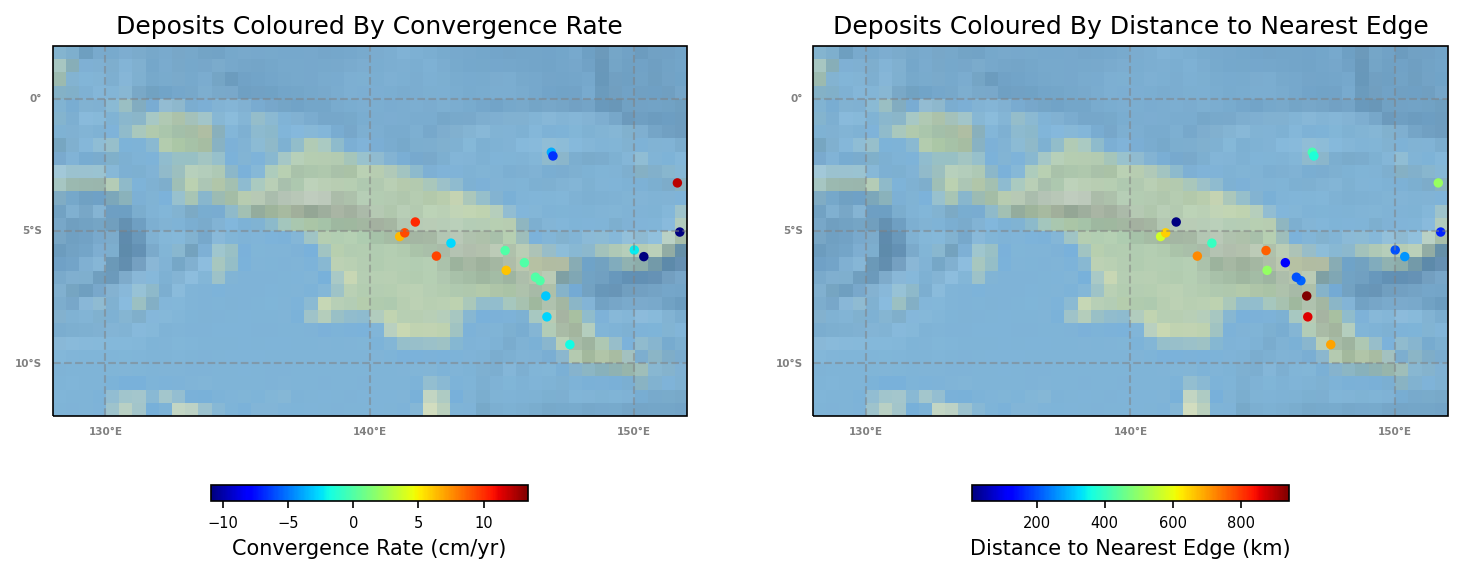

In [12]:
def set_ax(ax):
    ax.stock_img()
    ax.set_extent(Utils.get_region_of_interest_extent())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([130, 140, 150])
    gl.ylocator = mticker.FixedLocator([-10, -5, 0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

trench_file = Utils.get_convergence_dir() + 'subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12), dpi=150)
set_ax(ax1)
set_ax(ax2)

cb_1 = ax1.scatter(data['lon'], data['lat'], 50, marker='.', c=data['conv_rate'],  cmap=plt.cm.jet)
cb_2 = ax2.scatter(data['lon'], data['lat'], 50, marker='.', c=data['dist_nearest_edge']* 6371. * np.pi / 180,  cmap=plt.cm.jet)

ax1.title.set_text('Deposits Coloured By Convergence Rate')
ax2.title.set_text('Deposits Coloured By Distance to Nearest Edge')
cbar_1 = fig.colorbar(cb_1, shrink=0.5, ax=[ax1], orientation='horizontal', pad=0.05)
cbar_1.set_label('Convergence Rate (cm/yr)', size=10)
cbar_1.ax.tick_params(labelsize=7)
cbar_2 = fig.colorbar(cb_2, shrink=0.5, ax=[ax2], orientation='horizontal', pad=0.05)
cbar_2.set_label('Distance to Nearest Edge (km)', size=10)
cbar_2.ax.tick_params(labelsize=7)
plt.show()

In [ ]:
p_time = Utils.get_parameter('time')
start_time = p_time['start']
end_time = p_time['end']
time_step = p_time['step']

map_extent = [-180, 180, -90, 90]

rotation_files = Utils.get_parameter('rotation_files')
coastlines_file = Utils.get_parameter('coastlines')

positive = pd.read_csv(Utils.get_coreg_output_dir() + 'mineral_occurrences.csv')
negative = pd.read_csv(Utils.get_coreg_output_dir() + 'random_samples.csv')
candidates = pd.read_csv(Utils.get_coreg_output_dir() + 'samples.csv')
coreg_data =  pd.concat([positive, negative, candidates])

for time in range(start_time, end_time+1, 5):
# for time in range(0, 1, 10):
    # coastlines
    reconstructed_geometries = []
    pygplates.reconstruct(coastlines_file, rotation_files, reconstructed_geometries, time, 0)
    # terranes
    reconstructed_terranes = []
    terranes = Utils.get_parameter('terranes')
    if terranes:
        pygplates.reconstruct(terranes, rotation_files, reconstructed_terranes, time, 0)
   
    # plot the map
    fig = plt.figure(figsize=(16, 12), dpi=144)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent(map_extent)

    # plot coastlines
    for geom in reconstructed_geometries:
        lat, lon = zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
        plt.plot(lon, lat,
                 color='black', linewidth=.5, # the coastlines in black
                 transform=ccrs.Geodetic()
                )

    # plot terranes
    for geom in reconstructed_terranes:
        lat, lon = zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
        plt.plot(lon, lat,
                 color='black', linewidth=.5, # the terranes in black
                 transform=ccrs.Geodetic()
                )

    trench_data = Utils.get_trench_points(time)
    sub_idx = coreg_data[coreg_data['age']==time]['sub_idx'].dropna().unique()
    candidates_ =  candidates[candidates['age']==time][['recon_lon', 'recon_lat']].drop_duplicates()
    positive_ =  positive[positive['age']==time][['recon_lon', 'recon_lat']].drop_duplicates()
    negative_ =  negative[negative['age']==time][['recon_lon', 'recon_lat']].drop_duplicates()
    # print(sub_idx)
    # the subduction sample points are colored by property value
    ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 5, marker='.', color='blue')
    
    ax.scatter(trench_data.iloc[sub_idx]['trench_lon'], trench_data.iloc[sub_idx]['trench_lat'],
               10, marker='.', color='red', zorder=100)
    
    ax.scatter(candidates_['recon_lon'], candidates_['recon_lat'],
               5, marker='.', color='yellow')
    
    ax.scatter(positive_['recon_lon'], positive_['recon_lat'],
               5, marker='.', color='green')
    
    ax.scatter(negative_['recon_lon'], negative_['recon_lat'],
               5, marker='.', color='cyan')
   
    # fig.colorbar(cb, shrink=0.5, label='Distance To Nearest Edge(km)')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(-180, 180, 30))
    gl.ylocator = mticker.FixedLocator(range(-90, 90, 15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

    plt.title(f'Subduction Zones at {time} Ma')
    plt.savefig(Utils.get_tmp_dir() + f'subduction_zones_in_use_{time}_Ma.png', bbox_inches='tight', pad_inches=0)
    print(f'Plotting {time} Ma')
    plt.close()
    # plt.show()

In [ ]:
p_time = Utils.get_parameter('time')
start_time = p_time['start']
end_time = p_time['end']
time_step = p_time['step']

frame_list = [Utils.get_tmp_dir() + f'subduction_zones_in_use_{time}_Ma.png' for time in range(end_time, start_time-1, -5)]
clip = mpy.ImageSequenceClip(frame_list, fps=2)
clip.write_gif(Utils.get_tmp_dir() + 'subduction_zones_in_use.gif')
clip.write_videofile(Utils.get_tmp_dir() + 'subduction_zones_in_use.mp4')

print('done')

In [ ]:
video = io.open(Utils.get_tmp_dir() + 'subduction_zones_in_use.mp4', 'r+b').read()
# video = io.open('./tmp/subduction_zones_in_use.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width=960 alt="subduction zones animation" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

# Data Wrangling

In [13]:
# load data
coreg_input_data = pd.read_csv(Utils.get_coreg_input_dir() + 'mineral_occurrences.csv')
coreg_output_data = pd.read_csv(Utils.get_coreg_output_dir() + 'mineral_occurrences.csv')
print('The shape of coregistration input data is:', coreg_input_data.shape)
print('The shape of coregistration output data is:', coreg_output_data.shape)

if coreg_input_data.shape[0] == coreg_output_data.shape[0]:
    print('Good! The input and output data have the same length', coreg_output_data.shape[0], '\n')

print('The coregistration input data:')
display(coreg_input_data)
print('The coregistration output data:')
display(coreg_output_data)
print('The columns in coregistration output data are:')
Utils.print_columns()

The shape of coregistration input data is: (30, 5)
The shape of coregistration output data is: (30, 33)
Good! The input and output data have the same length 30 

The coregistration input data:


index     lon   lat  age  plate_id
0       0  146.67 -7.46    4       698
1       1  145.86 -6.20    9       698
2       2  152.63 -3.13    1       847
3       3  141.14 -5.21    1       615
4       4  155.50 -6.33    3       847
5       5  143.08 -5.46    6       615
6       6  146.88 -2.02   15       847
7       7  145.17 -6.49    0       615
8       8  141.73 -4.66   14       698
9       9  153.61 -4.09    1       847
10     10  147.58 -9.30    4       698
11     11  160.03 -9.78    2       847
12     12  151.65 -3.18   34       847
13     13  160.16 -9.61   23       847
14     14  146.94 -2.16   14       847
15     15  150.38 -5.97   25       830
16     16  150.02 -5.72   24       830
17     17  141.33 -5.07    2       615
18     18  146.45 -6.88    9       698
19     19  145.13 -5.74    7       698
20     20  142.53 -5.95    2       615
21     21  151.74 -5.04   25       830
22     22  156.04 -6.84    4       847
23     23  159.73 -9.37   24       847
24     24  146.71 -8.25    5       615
25     25  158.07 -8.75    3       847
26     26  157.52 -8.08    4       847
27     27  159.83 -9.43   24       847
28     28  160.08 -9.69    2       847
29     29  146.28 -6.75   12       698

The coregistration output data:


lon   lat   age  plate_id  recon_lon  recon_lat  distance  sub_idx  \
0   146.67 -7.46   4.0     698.0    145.944    -10.107     0.033    839.0   
1   145.86 -6.20   9.0     698.0    144.242    -12.046     0.033    825.0   
2   152.63 -3.13   1.0     847.0    153.350     -3.407     0.041   2535.0   
3   141.14 -5.21   1.0     615.0    140.941     -5.890     0.037   2642.0   
4   155.50 -6.33   3.0     847.0    157.648     -7.180     0.016   1331.0   
5   143.08 -5.46   6.0     615.0    141.916     -9.517     0.049    821.0   
6   146.88 -2.02  15.0     847.0    155.591     -4.856     0.025   1265.0   
7   145.17 -6.49   0.0     615.0    145.170     -6.490     0.031   2689.0   
8   141.73 -4.66  14.0     698.0    139.146    -13.651     0.138   1182.0   
9   153.61 -4.09   1.0     847.0    154.329     -4.369     0.028   2531.0   
10  147.58 -9.30   4.0     698.0    146.894    -11.931     0.054    851.0   
11  160.03 -9.78   2.0     847.0    161.458    -10.359     0.004   1260.0   
12  151.65 -3.18  34.0     847.0    156.280    -12.759     0.021    963.0   
13  160.16 -9.61  23.0     847.0    168.995    -12.129     0.038   2292.0   
14  146.94 -2.16  14.0     847.0    155.630     -5.075     0.014   1255.0   
15  150.38 -5.97  25.0     830.0    159.624     -5.758     0.008   1564.0   
16  150.02 -5.72  24.0     830.0    159.492     -5.358     0.012   1549.0   
17  141.33 -5.07   2.0     615.0    140.934     -6.431     0.036   2643.0   
18  146.45 -6.88   9.0     698.0    144.869    -12.703     0.037    830.0   
19  145.13 -5.74   7.0     698.0    143.819    -10.372     0.033    861.0   
20  142.53 -5.95   2.0     615.0    142.143     -7.303     0.040   2651.0   
21  151.74 -5.04  25.0     830.0    161.266     -5.928     0.014   1569.0   
22  156.04 -6.84   4.0     847.0    158.904     -7.977     0.015   1474.0   
23  159.73 -9.37  24.0     847.0    168.584    -11.863     0.034    998.0   
24  146.71 -8.25   5.0     615.0    145.822    -11.560     0.049    825.0   
25  158.07 -8.75   3.0     847.0    160.212     -9.612     0.008   1312.0   
26  157.52 -8.08   4.0     847.0    160.381     -9.226     0.014   1462.0   
27  159.83 -9.43  24.0     847.0    168.684    -11.924     0.035    998.0   
28  160.08 -9.69   2.0     847.0    161.508    -10.270     0.006   1260.0   
29  146.28 -6.75  12.0     698.0    144.235    -14.361     0.037    769.0   

    trench_lon  trench_lat  ...  trench_abs_paral  subducting_abs_rate  \
0       146.64       -8.34  ...              2.70                 7.63   
1       145.23      -10.43  ...              2.12                 7.06   
2       153.31       -5.73  ...             -7.30                -7.26   
3       141.61       -3.87  ...              1.91                 8.07   
4       157.25       -7.98  ...             -7.87                -7.00   
5       143.70       -7.34  ...              3.24                 7.20   
6       156.30       -6.08  ...             -2.30                 0.91   
7       146.23       -5.08  ...              6.79                -7.55   
8       142.32       -6.38  ...             -6.44                -6.64   
9       153.91       -5.93  ...             -7.41                -7.22   
10      148.62       -9.35  ...              3.74                 7.51   
11      161.42      -10.61  ...             -8.27                -6.60   
12      157.01      -11.77  ...             -1.08                -3.63   
13      169.54      -10.03  ...              0.16                 7.90   
14      156.05       -5.76  ...             -4.81                 0.90   
15      159.99       -6.08  ...             -1.23                -9.75   
16      159.93       -5.88  ...             -1.24                 0.34   
17      142.03       -4.66  ...              2.55                -8.40   
18      146.04      -10.94  ...              2.12                 7.00   
19      144.93       -8.80  ...              2.11                 7.11   
20      143.30       -5.33  ...              2.40                

The columns in coregistration output data are:
* 0 reconstructed mineral deposits longitude
* 1 reconstructed mineral deposits latitude
* 2 distance to the nearest trench point
* 3 the index of trench point
* 4 trench point longitude
* 5 trench point latitude
* 6 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 7 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 8 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 9 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 10 length of arc segment (in degrees) that current point is on
* 11 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 12 subducting plate ID
* 13 trench plate ID
* 14 distance (in degrees) along the trench line to the nearest trench edge
* 15 the distance (in degrees) along the trench line from

In [14]:
coreg_out_dir = Utils.get_coreg_output_dir()
positive_data = pd.read_csv(coreg_out_dir + '/mineral_occurrences.csv')
unlabelled_data = pd.read_csv(coreg_out_dir + '/random_samples.csv')
samples_data = pd.read_csv(coreg_out_dir + '/samples.csv')

positive_data = positive_data.dropna()
unlabelled_data = unlabelled_data.dropna()
samples_data = samples_data.dropna()

if positive_data.shape[1] != unlabelled_data.shape[1] or positive_data.shape[1] != samples_data.shape[1] or unlabelled_data.shape[1] != samples_data.shape[1]:
    print('The number of features differs for the input datasets!')
    print('Number of features for positive samples:', positive_data.shape[1])
    print('Number of features for unlabelled samples:', unlabelled_data.shape[1])
    print('Number of features for samples:', samples_data.shape[1])

positive_data['label'] = 1
unlabelled_data['label'] = 0

# save the data
ml_input_dir = Utils.get_ml_input_dir()

if not os.path.isdir(ml_input_dir):
    os.mkdir(ml_input_dir)

positive_data.to_csv(ml_input_dir + 'mineral_occurrences.csv', index=False)
unlabelled_data.to_csv(ml_input_dir + 'random_samples.csv', index=False)
samples_data.to_csv(ml_input_dir + 'samples.csv', index=False)

files = glob.glob(ml_input_dir + '*')
print('Generated files:')
for f in files:
    print(f)

Generated files:
ml_input\mineral_occurrences.csv
ml_input\random_samples.csv
ml_input\samples.csv


In [16]:
positive_features = positive_data[positive_data.columns[4:-1]]
unlabelled_features = unlabelled_data[unlabelled_data.columns[4:-1]]
features_all = pd.concat([positive_features, unlabelled_features]).reset_index(drop=True)
samples_features = samples_data[samples_data.columns[4:]]

positive_labels = positive_data[positive_data.columns[-1]]
unlabelled_labels = unlabelled_data[unlabelled_data.columns[-1]]
labels = pd.concat([positive_labels, unlabelled_labels]).reset_index(drop=True)

# drop highly correlated features
# create a correlation matrix
corr_matrix = features_all.corr(method='spearman').abs()
# select the upper triangle of the correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# find features with the correlation greater than 0.7
corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
# drop features
features = features_all.drop(corr_drop, axis=1)
features_list = features.columns.tolist()

scaler = StandardScaler()
features = scaler.fit_transform(features)

features = pd.DataFrame(features, columns=features_list)
samples_features = samples_features[samples_features.columns.intersection(features.columns)]

features_labels = pd.concat([features, labels], axis=1).reset_index(drop=True)

print('Number of positive samples:', positive_features.shape[0])
print('Number of unlabelled samples:', unlabelled_features.shape[0])
print('Number of features:', features.shape[1])

# f = plt.figure(figsize=(30, 15))
# plt.matshow(features_all.corr(), fignum=f.number)
# plt.xticks(range(features_all.select_dtypes(['number']).shape[1]), features_all.select_dtypes(['number']).columns, fontsize=14, rotation=90)
# plt.yticks(range(features_all.select_dtypes(['number']).shape[1]), features_all.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)

corr = features_all.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
# corr.style.background_gradient(cmap='coolwarm', axis=None) # normalise color
# corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'}) # remove numbers

# corr = features_all.corr()
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

Number of positive samples: 30
Number of unlabelled samples: 121
Number of features: 17


# Machine Learning

In [17]:
# generate a confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    '''pretty print for confusion matrixes'''
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = ' ' * columnwidth
    print('    ' + empty_cell, end=' ')
    for label in labels:
        print('%{0}s'.format(columnwidth) % 'pred_' + label, end=' ')
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print('    %{0}s'.format(columnwidth) % 'true_' + label1, end=' ')
        for j in range(len(labels)):
            cell = '%{0}.1f'.format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=' ')
        print()

features_labels_pul = features_labels.sample(frac=1).reset_index(drop=True)
features_pul = features_labels_pul[features_labels_pul.columns[:-1]].copy()
labels_pul = features_labels_pul[features_labels_pul.columns[-1]].copy()

# hide 30 percent of the samples labelled one
hidden_size = round(0.3 * (labels_pul==1).sum())

labels_pul_training = labels_pul.copy()
rand_ind = np.random.choice(labels_pul_training[labels_pul_training==1].index, replace=False, size=hidden_size)
labels_pul_training.loc[rand_ind] = 0

# Random Forest model structure
rf = RandomForestClassifier(n_jobs=-1, random_state=1)

print('Parameters currently in use:\n')
pprint(rf.get_params())

# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

rf.fit(features_pul, labels_pul_training)

print('')
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf.predict(features_pul)))

# print('')
# print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
# print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
# print('')
# print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
# print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
# print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
# print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
# # print('ROC AUC score: ', roc_auc_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        121.0          0.0 
           true_positive          9.0         21.0 
None

Precision:  1.0
Recall:  0.7
Accuracy:  0.9403973509933775
F1 score:  0.8235294117647058
ROC AUC score:  0.85


In [ ]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(20, 220, 20)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 110, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# use the random grid to search for best hyperparameters
# random search of hyperparameters using 10 fold cross validation
# search across 100 different combinations and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)

# fit the random search model
rf_random.fit(features_pul, labels_pul_training)

In [ ]:
# best set of hyperparameters
rf_random.best_params_

In [ ]:
# run the Random Forest classifier using the best set of hyperparameters
rf_random_best = rf_random.best_estimator_
rf_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_random_best.predict(features_pul)))

In [18]:
# create the parameter grid based on the results of the random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [30, 40, 50]
}

# instantiate the grid search model
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
rf_grid.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 40, 50]},
             verbose=2)

In [19]:
# best set of hyperparameters
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 30}

In [20]:
# run the Random Forest classifier using the best set of hyperparameters
rf_grid_best = rf_grid.best_estimator_
# rf_grid_best = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features='auto',
#                                       max_depth=2, n_jobs=-1, random_state=1)
rf_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_grid_best.predict(features_pul)))

# print('')
# print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
# print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
# print('')
# print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
# print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
# print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
# print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        121.0          0.0 
           true_positive         12.0         18.0 
None

Precision:  1.0
Recall:  0.6
Accuracy:  0.9205298013245033
F1 score:  0.7499999999999999
ROC AUC score:  0.8


In [21]:
bc = BaggingPuClassifier(rf_grid_best, max_samples=int(sum(labels_pul_training)), n_jobs=-1, random_state=1)
bc.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc.predict(features_pul)))

# print('')
# print('---- {} ----'.format('Bagging PU (Hidden Samples)'))
# print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
# print('')
# print('Precision: ', precision_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
# print('Recall: ', recall_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
# print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
# print('F1 score: ', f1_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))

---- Bagging PU ----
                        pred_negative        pred_positive 
           true_negative        108.0         13.0 
           true_positive          0.0         30.0 
None

Precision:  0.6976744186046512
Recall:  1.0
Accuracy:  0.9139072847682119
F1 score:  0.8219178082191781
ROC AUC score:  0.9462809917355373


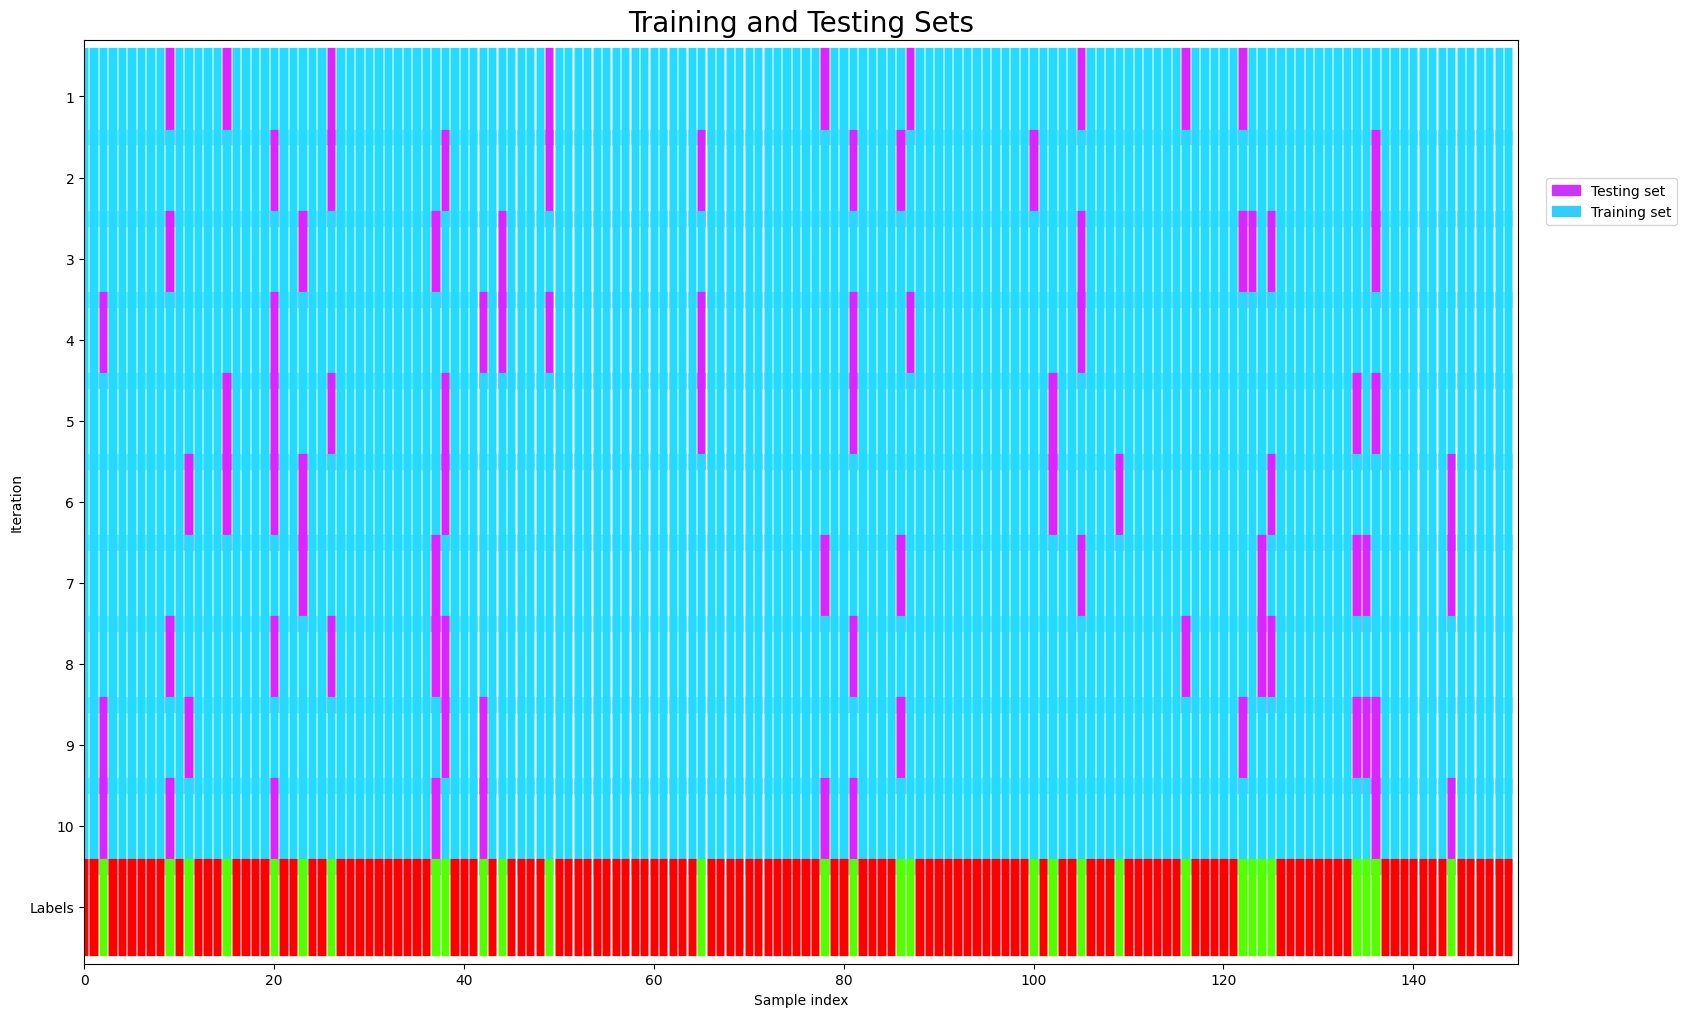

In [22]:
# generate different sets of training samples
iter_num = 10
labels_pul_training_all = np.empty((features_labels_pul.shape[0], iter_num))

# plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()

for i in range(iter_num):
    # hide positive samples
    labels_pul_training = labels_pul.copy()
    labels_pul_training.loc[
        np.random.choice(
            labels_pul_training[labels_pul_training==1].index,
            replace=False,
            size=hidden_size
            )
        ] = 0
    
    labels_pul_training_all[:, i] = labels_pul_training
        
    # fill in indices with the training/testing groups
    indices = labels_pul - labels_pul_training

    # visualise the results
    ax.scatter(range(len(indices)), [i+.5]*len(indices),
                   c=indices, marker='_', lw=70, cmap='cool',
                   vmin=-.2, vmax=1.2)

# plot the data classes and groups at the end
ax.scatter(range(len(features_labels_pul)), [i+1.5]*len(features_labels_pul), c=labels_pul, marker='_', lw=70, cmap='prism')

n_splits = iter_num
yticklabels = list(range(1, n_splits+1)) + ['Labels']
ax.set(yticks=np.arange(n_splits+1)+0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel='Iteration',
           ylim=[n_splits+1.2, -.2], xlim=[0, len(features_labels_pul)])
ax.set_title('Training and Testing Sets', fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
fig.set_size_inches(18.5, 12)

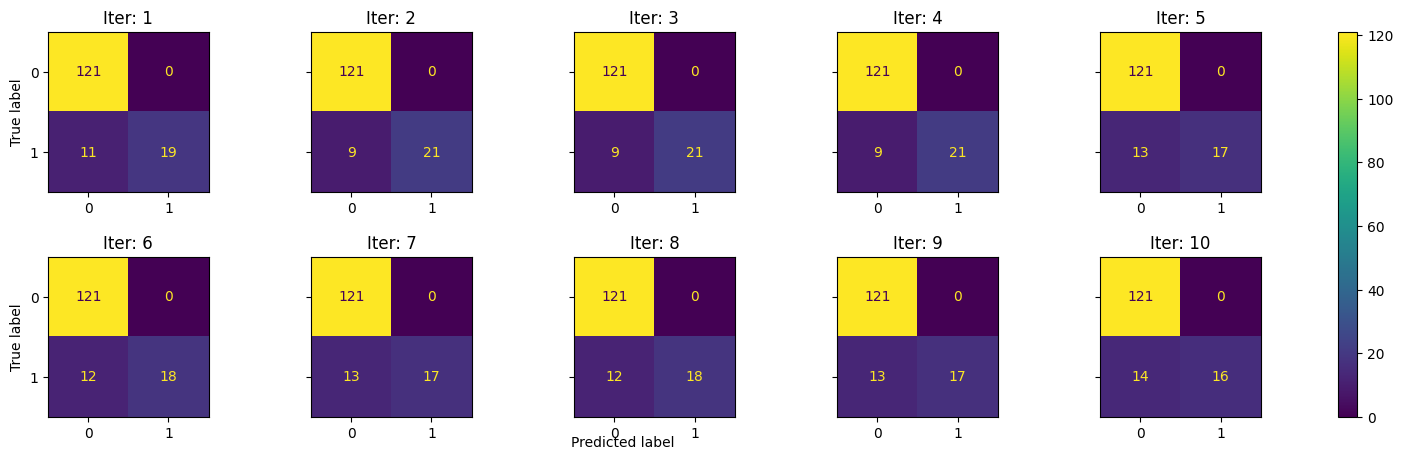

In [23]:
# confusion matrices for different sets of training and testing samples
# plt.rcParams.update({'font.size': 8})
f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

j = 0
k = 0

for i in range(iter_num):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    pred = rf_grid_best.predict(features_pul)
    
    cf_matrix = confusion_matrix(labels_pul, pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[j, k])
    disp.ax_.set_title('Iter: '+str(i+1))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0 and i!=5:
        disp.ax_.set_ylabel('')
    
    k += 1
    if i == 4:
        j = 1
        k = 0

f.text(0.4, 0.05, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [24]:
# run the Random Forest classifier for ten times and take the average of feature importance values
importances = np.empty((len(features_list), iter_num))

for i in range(iter_num):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    importances[:, i] = rf_grid_best.feature_importances_

importances_mean = importances.mean(axis=1)
importances_var = importances.var(axis=1)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features_list, importances_mean)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)
[print('Feature: {:60} Importance: {}'.format(*pair)) for pair in feature_importances]

with open(f'feature_importance.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(feature_importances)

Feature: recon_lon                                                    Importance: 0.29711
Feature: subducting_abs_angle                                         Importance: 0.10969
Feature: seafloor_age                                                 Importance: 0.07177
Feature: trench_norm                                                  Importance: 0.0622
Feature: sub_idx                                                      Importance: 0.05425
Feature: trench_abs_paral                                             Importance: 0.04987
Feature: trench_abs_rate                                              Importance: 0.04678
Feature: trench_pid                                                   Importance: 0.04609
Feature: trench_abs_angle                                             Importance: 0.04318
Feature: dist_nearest_edge                                            Importance: 0.04059
Feature: subducting_abs_rate                                          Importance: 0.03701
Feature: co

Number of features for 90% importance: 13


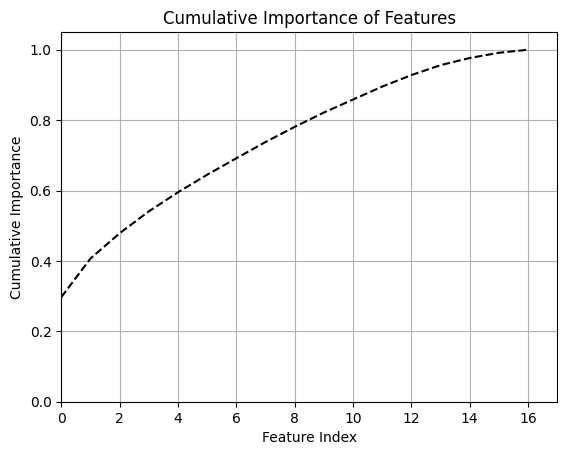

In [25]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)
# make a linear graph
x_values = list(range(len(feature_importances)))
plt.plot(x_values, cumulative_importances, 'k--')
# draw a line at 99% of the importance retained
# plt.hlines(y=0.99, xmin=0, xmax=len(sorted_importances), color='r', linestyles='dashed')
# format x ticks and labels
# plt.xticks(x_values, sorted_features, rotation='vertical')
# axis labels and title
plt.xlabel('Feature Index'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importance of Features');
plt.grid()
plt.ylim(0, 1.05)
plt.xlim(0, len(feature_importances))

important_features_num = np.where(cumulative_importances > 0.9)[0][0]+1
print('Number of features for 90% importance:', important_features_num)
# important_features_num = np.where(cumulative_importances > 0.95)[0][0]+1
# print('Number of features for 95% importance:', important_features_num)
# important_features_num = np.where(cumulative_importances > 0.99)[0][0]+1
# print('Number of features for 99% importance:', important_features_num)

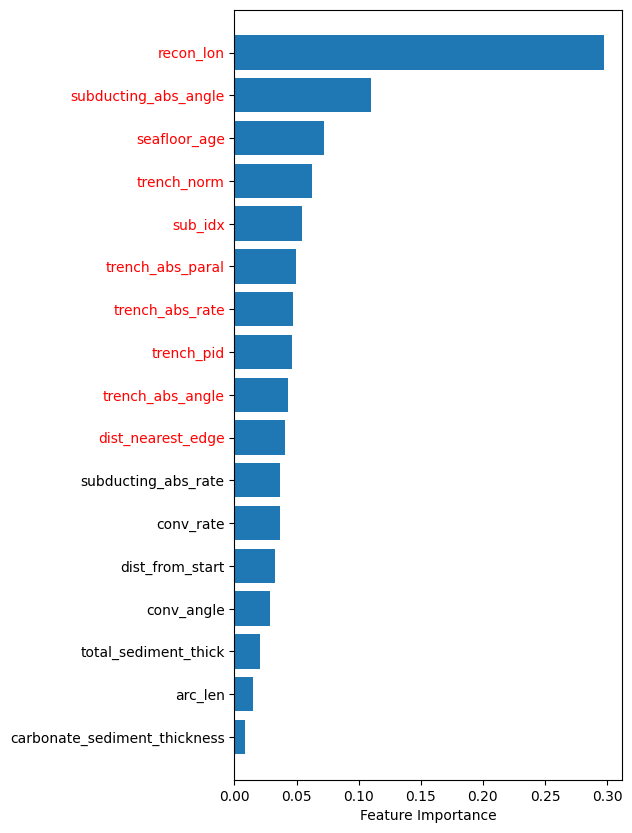

In [26]:
# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
feature_importances_plot = feature_importances[-40:]

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances_plot]
y_pos = np.arange(len(feature_importances_plot))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances_plot])

# highlight top 10 features
for i in range(len(ft_imps)-10, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()

In [27]:
# run the model for ten times using different sets of training samples and take the average of probability values for each target point
probs = np.empty((samples_features.shape[0], iter_num))

for i in range(iter_num):
#     bc = BaggingPuClassifier(rf_grid_best, n_estimators=50, max_samples=int(sum(labels_pul_training_all[:, i])),
#                          n_jobs=-1, random_state=1)
    bc.fit(features_pul, labels_pul_training_all[:, i])
    probs[:, i] = bc.predict_proba(samples_features)[:, 1]

# comment this section and uncomment the next one if interested to see original probability scores
# --------------------
scaler = MinMaxScaler()
point_probs = scaler.fit_transform(probs)
point_probs_mean = point_probs.mean(axis=1)
point_probs_var = point_probs.var(axis=1)

# --------------------
# point_probs_mean = probs.mean(axis=1)
# point_probs_var = probs.var(axis=1)

samples_features_xy = samples_features.copy()
samples_features_xy['lon'] = samples_data['lon']
samples_features_xy['lat'] = samples_data['lat']
samples_features_xy['prob'] = point_probs_mean
samples_features_xy['var'] = point_probs_var
probs = samples_features_xy.groupby(['lat', 'lon'])['prob'].mean().reset_index()

### Average Probability

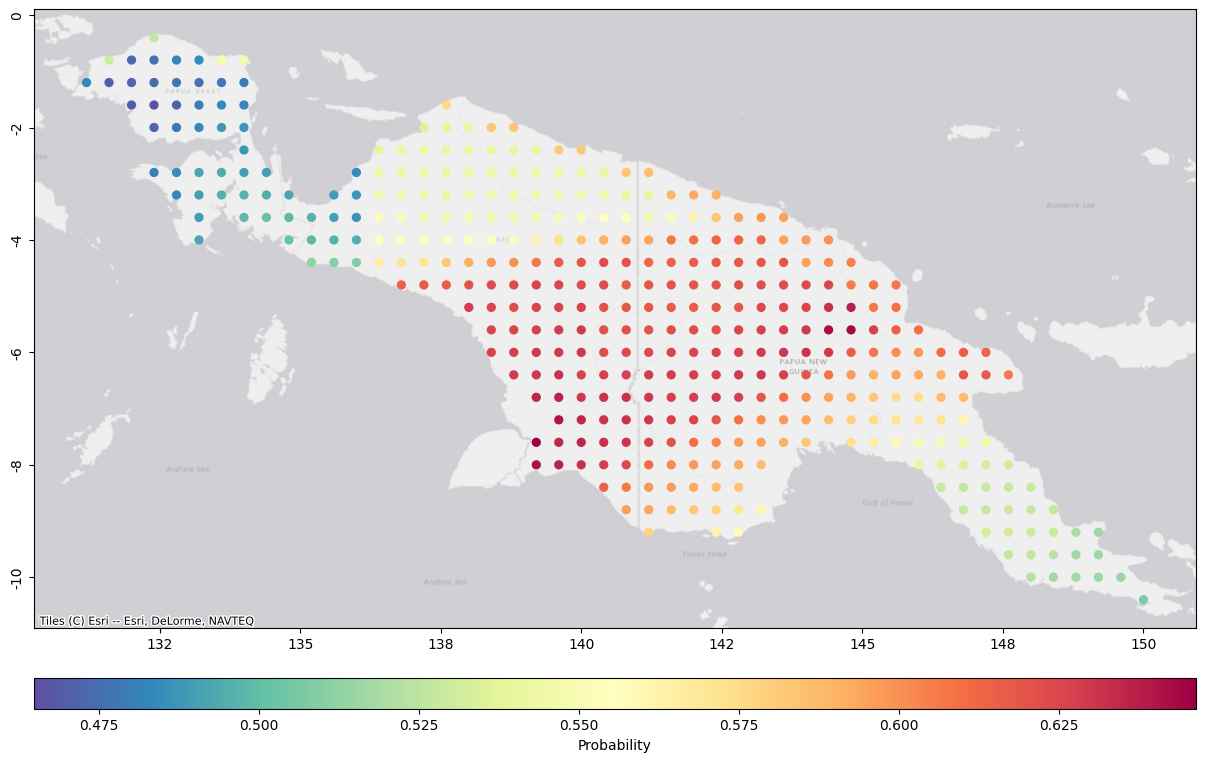

In [28]:
plot_x = probs['lon']
plot_y = probs['lat']

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x, plot_y, 32., c=probs['prob'], cmap='Spectral_r')

# sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

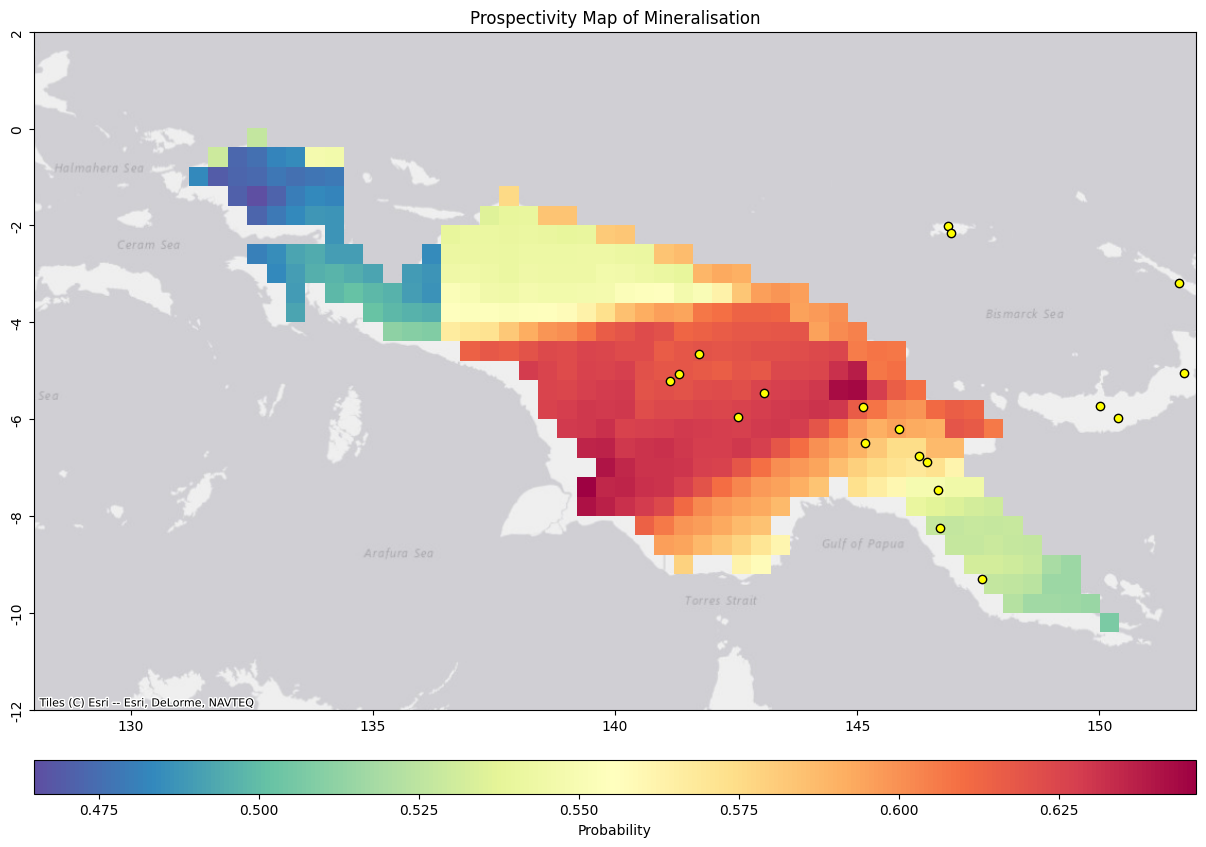

In [29]:
# create a probability map using the target points
probabilities = []
count = 0

for mask in mask_coords['include']:
    if mask:
        probabilities.append(probs['prob'][count])
        count += 1
    else:
        probabilities.append(np.nan)

probabilities_2d = np.reshape(probabilities, (ny, nx))
probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim([128, 152])
ax.set_ylim([-12, 2])

ax.scatter(min_occ_data['lon'], min_occ_data['lat'], color='yellow', edgecolors='black')
# sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(128, 152, -12, 2))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of Mineralisation')
plt.show()

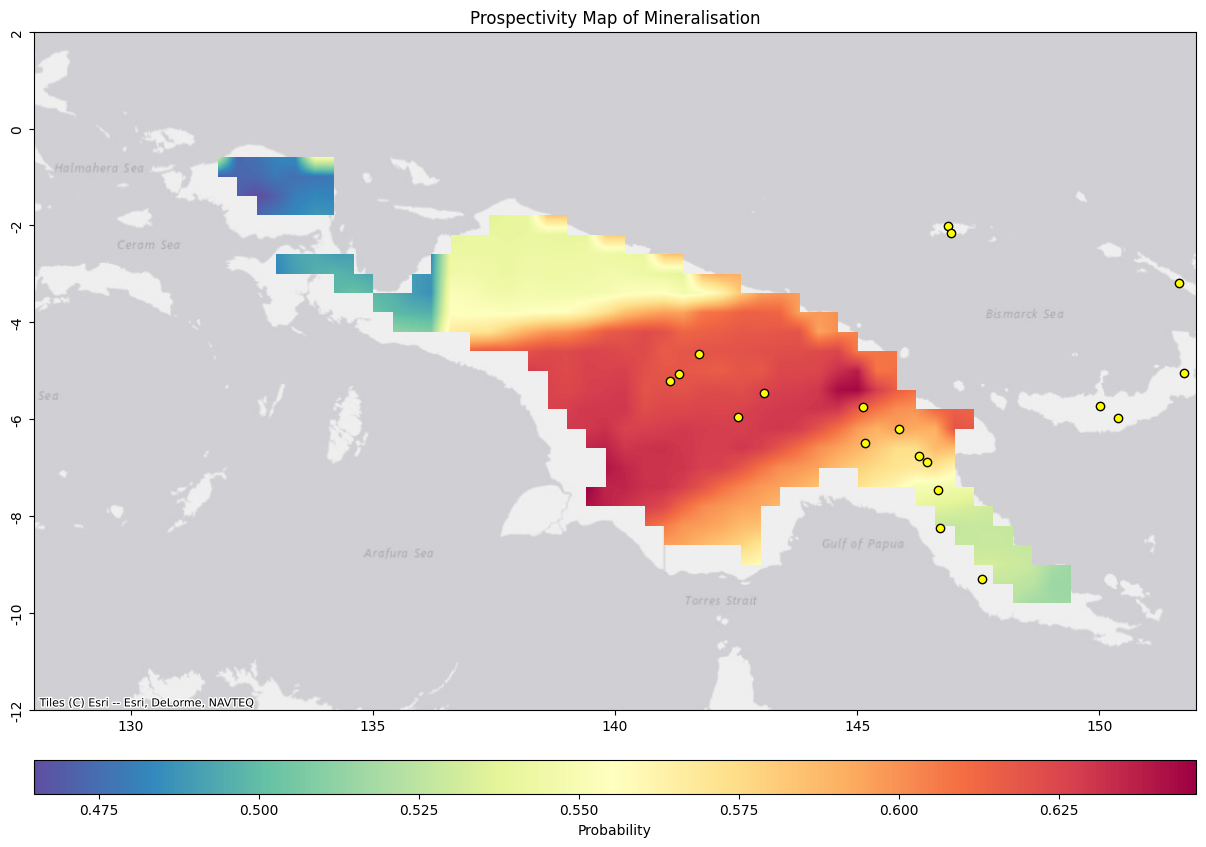

In [30]:
# plot an interpolated probability map
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim([128, 152])
ax.set_ylim([-12, 2])

ax.scatter(min_occ_data['lon'], min_occ_data['lat'], color='yellow', edgecolors='black')
# sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear',
           extent=(128, 152, -12, 2))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of Mineralisation')
plt.show()

### Variance

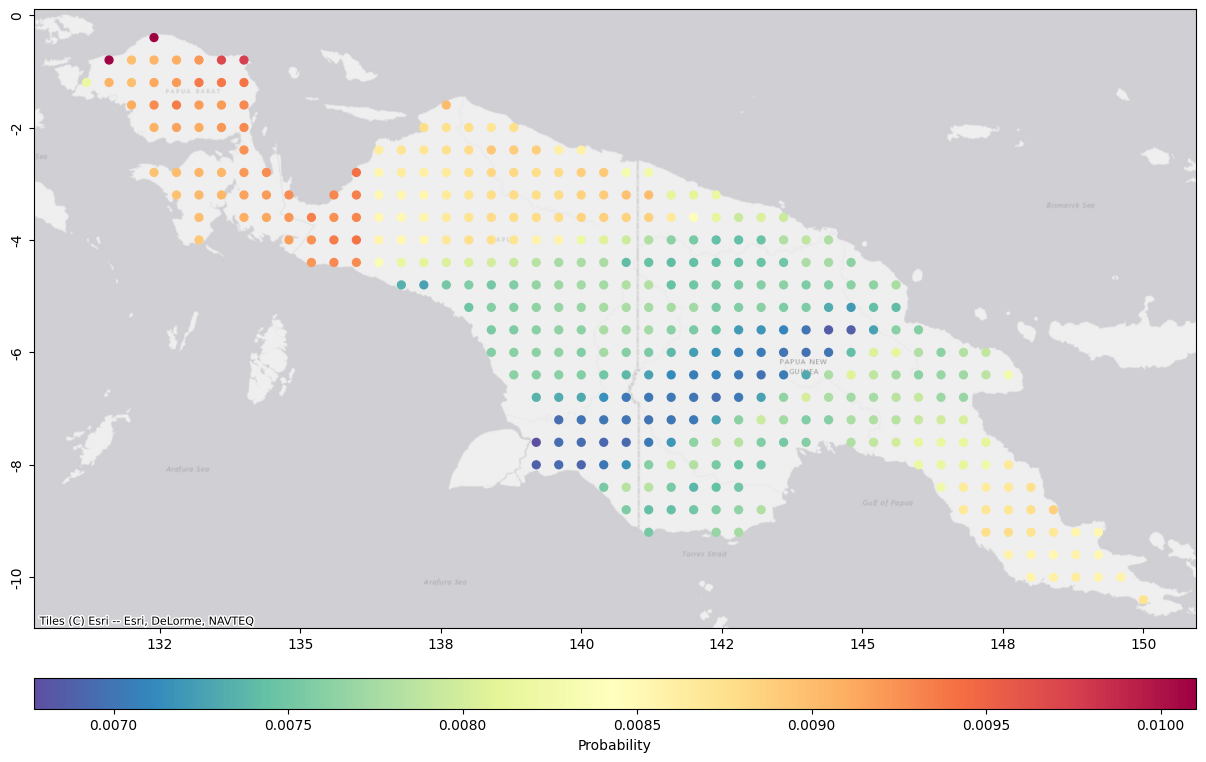

In [31]:
samples_features_xy = samples_features.copy()
samples_features_xy['lon'] = samples_data['lon']
samples_features_xy['lat'] = samples_data['lat']
samples_features_xy['prob'] = point_probs_mean
samples_features_xy['var'] = point_probs_var
probs = samples_features_xy.groupby(['lat', 'lon'])['var'].mean().reset_index()

plot_x = probs['lon']
plot_y = probs['lat']

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x, plot_y, 32., c=probs['var'], cmap='Spectral_r')

# sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

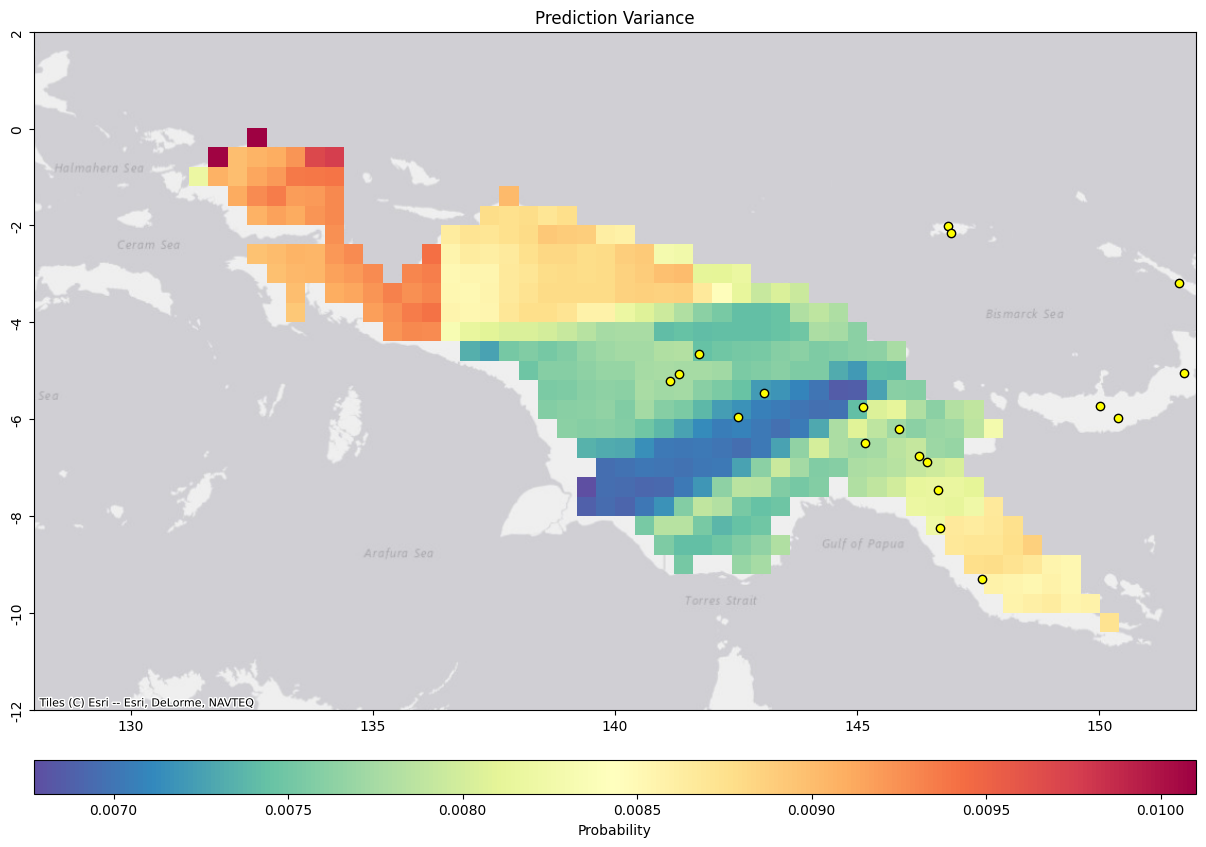

In [32]:
# create a probability map using the target points
probabilities = []
count = 0

for mask in mask_coords['include']:
    if mask:
        probabilities.append(probs['var'][count])
        count += 1
    else:
        probabilities.append(np.nan)

probabilities_2d = np.reshape(probabilities, (ny, nx))
probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim([128, 152])
ax.set_ylim([-12, 2])

ax.scatter(min_occ_data['lon'], min_occ_data['lat'], color='yellow', edgecolors='black')
# sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(128, 152, -12, 2))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prediction Variance')
plt.show()

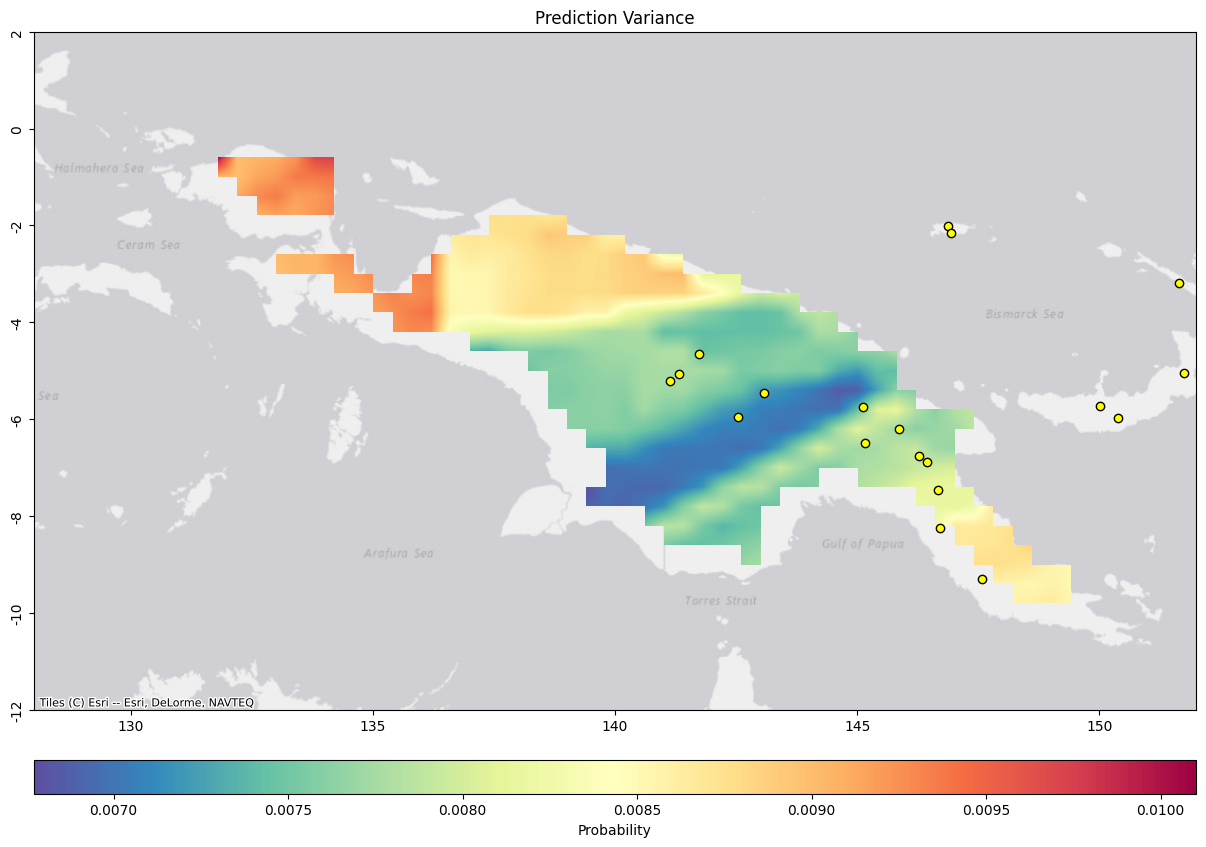

In [33]:
# plot an interpolated probability map
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim([128, 152])
ax.set_ylim([-12, 2])

ax.scatter(min_occ_data['lon'], min_occ_data['lat'], color='yellow', edgecolors='black')
# sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear',
           extent=(128, 152, -12, 2))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prediction Variance')
plt.show()